In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import re
import string
import joblib

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
import torch
torch.cuda.is_available()


True

In [3]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "latin_1", names = ['target', 'ids', 'date', 'flag', 'user', 'text'])
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df['text'][1]

"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

In [5]:
df.shape

(1600000, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df['flag'].describe()

count      1600000
unique           1
top       NO_QUERY
freq       1600000
Name: flag, dtype: object

In [9]:
# 0 -> negative , 4 -> positive
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [10]:
# replacing 4 with 1 for positive
df['target'] = df['target'].replace(4,1)
df.tail()

,target,ids,date,flag,user,text
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,1,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [11]:
#get word count per text
def word_count(text):
    return len(text.split())

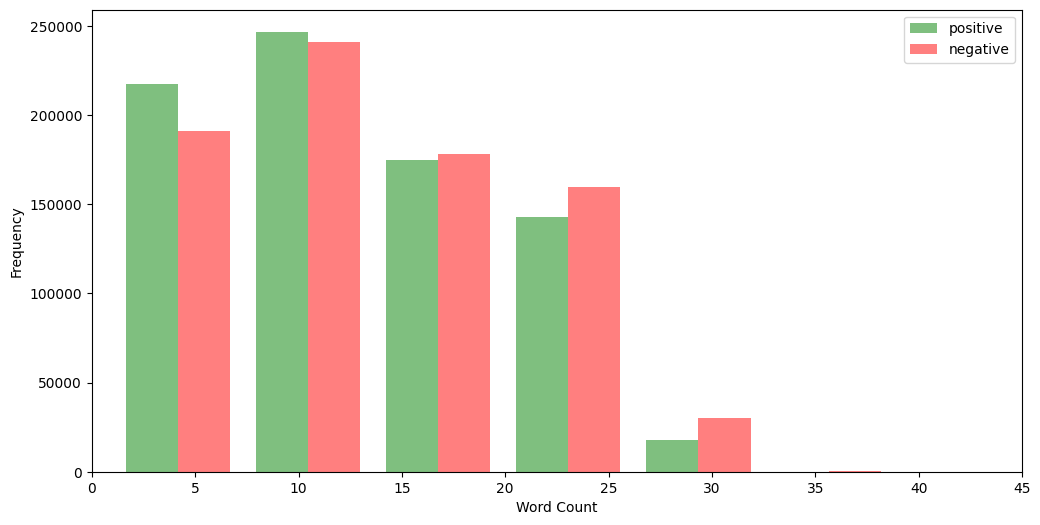

In [12]:
# ploting word count distribution for both negative and positive sentence
df['word_count'] = df['text'].apply(word_count)
p = df['word_count'][df.target == 1]
n = df['word_count'][df.target == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
g = plt.hist([p,n], color=['g','r'], alpha=0.5, label = ['positive','negative'])
plt.legend(loc='upper right')

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

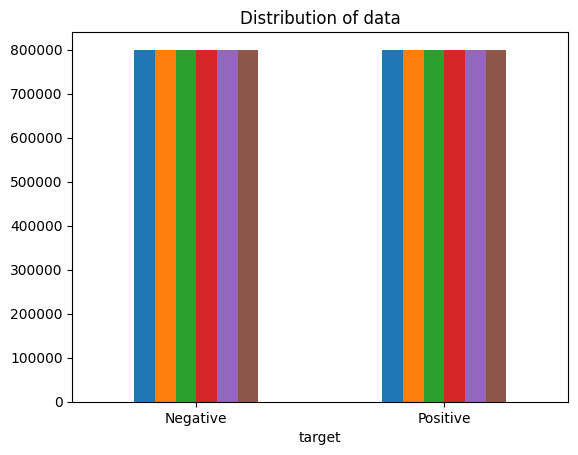

In [13]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',
                                              legend = False )
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [14]:
df.head()

,target,ids,date,flag,user,text,word_count
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",19
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,21
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,18
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,10
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",21


In [15]:
df.drop(['ids','date','flag','user','word_count'], axis = 1, inplace = True)

In [16]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [17]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [18]:
df['text'] = df['text'].astype('str') 

In [19]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
DO_NOT_REMOVE = {
    "not", "no", "never", "none", "nobody", "nothing", "neither", "nowhere",
    "cannot", "can't", "won't", "don't", "didn't", "isn't", "aren't",
    "wasn't", "weren't", "hasn't", "haven't", "hadn't",
    "wouldn't", "shouldn't", "couldn't", "mustn't",
    "very", "too", "so", "quite", "really", "extremely",
    "but", "however", "although", "though", "yet",
    "if", "unless", "until", "without"
}
stopword = stopword - DO_NOT_REMOVE
print(stopword)

{'i', "he'd", 'while', 'needn', 'him', 'ain', 'do', 'was', "he'll", 'those', 'hasn', 'isn', 's', 'd', 'hers', "mightn't", 'its', "needn't", 'whom', 'hadn', "that'll", 'an', 'did', "she'll", 'after', "they've", 'ourselves', "i've", 'have', 'having', 'we', 'up', 'nor', 'now', 'any', 'he', 'herself', 'yourselves', 'both', 'shan', "we're", 'they', "you've", "they'd", "it's", 'each', 'just', "we'll", 'below', 'from', "i'm", "she's", 'am', 'as', 'for', 'their', 'himself', 'where', 'yours', "i'll", 'other', 'that', 'it', 'then', "we've", 'had', 'm', 'into', "it'll", "i'd", 'and', 'above', 'ours', "it'd", 'won', 'don', 'by', 'this', "should've", "they'll", 'before', 'more', 'our', 'there', 'is', "they're", 'wouldn', "you're", 'who', 'between', 'down', 'itself', 're', 'out', 'during', 'on', 'off', 'y', 'when', "she'd", 'because', 'these', 'couldn', 'me', 'haven', 'mustn', 'once', 'mightn', 'again', 'what', 'at', 'all', 't', 'some', 'about', 'why', 'a', 'shouldn', 'how', 'the', 'yourself', "does

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = r'@[^\s]+'
stopword = set(stopword)
wordLemm = WordNetLemmatizer()

In [22]:
def process_tweets_ml(tweet):
  # Lower Casing
    tweet = str(tweet).lower()
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    #Remove punctuations
    tweet = re.sub(r"[^\w\s]", '', tweet)
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    #reducing a word to its word stem 
    finalwords = [
        wordLemm.lemmatize(w)
        for w in tokens
            if w not in stopword and len(w) > 1
    ]
    return ' '.join(finalwords)

In [37]:

df['processed_tweets'] = df['text'].apply(lambda x : process_tweets_ml(x))

In [38]:
df['processed_tweets'][1000]

'um would hell no fugly poker dog pant cruise hi jonathan sorry missed'

In [41]:
X = df['processed_tweets'].values
y = df['target'].values

In [42]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [43]:
#converting a colleaction of raw documents to a matrix of tf-idf features
vector = TfidfVectorizer(sublinear_tf= True  , max_features=50000,
    ngram_range=(1,2))
X = vector.fit_transform(X)

In [44]:
X.shape

(1600000, 50000)

Train Accuracy: 0.8146328125
Test Accuracy : 0.80403125


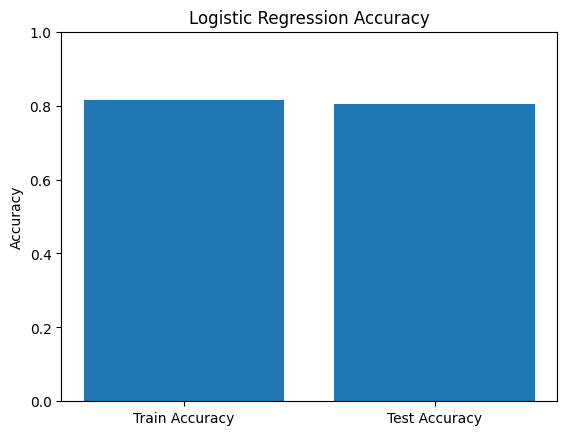

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 101)

# Logistic regression
lg = LogisticRegression()
history = lg.fit(X_train, y_train)

train_pred = lg.predict(X_train)
test_pred = lg.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)
print("Train Accuracy:", train_acc)
print("Test Accuracy :", test_acc)

labels = ['Train Accuracy', 'Test Accuracy']
values = [train_acc, test_acc]

plt.figure()
plt.bar(labels, values)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy")
plt.show()

In [52]:
import joblib
joblib.dump(vector, "/kaggle/working/tfidf.pkl")
joblib.dump(lg, "/kaggle/working/logreg.pkl")


['/kaggle/working/logreg.pkl']

In [50]:
!ls models


logreg.pkl  tfidf.pkl


# Using LSTM

In [ ]:
import keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import re

urlPattern = r"http\S+|www\S+"
userPattern = r"@\w+"

def process_tweets_lstm(tweet):
    tweet = str(tweet).lower()
    
    # remove URLs
    tweet = re.sub(urlPattern, '', tweet)
    
    # remove mentions
    tweet = re.sub(userPattern, '', tweet)
    
    # remove hashtags symbol but keep word
    tweet = re.sub(r"#", "", tweet)
    
    # remove numbers
    tweet = re.sub(r"\d+", "", tweet)
    
    # remove punctuation & special characters
    tweet = re.sub(r"[^a-z\s]", "", tweet)
    
    # remove extra spaces
    tweet = re.sub(r"\s+", " ", tweet).strip()
    
    return tweet


In [ ]:
df['processed_tweets_lstm'] = df['text'].apply(lambda x : process_tweets_lstm(x))

In [ ]:
tokenizer = Tokenizer(num_words = 7000)
tokenizer.fit_on_texts(df['processed_tweets_lstm'])

In [ ]:
len(tokenizer.word_index)

In [ ]:
list(tokenizer.word_index.items())[:20]


In [ ]:
tokenizer.word_counts

In [ ]:
sequence = tokenizer.texts_to_sequences(df['processed_tweets_lstm'])

In [ ]:
print(df['processed_tweets_lstm'][0])
print(sequence[0])

In [ ]:
max_len = max([len(x) for x in sequence])

In [ ]:
max_len

In [ ]:
X = pad_sequences(sequence, maxlen=max_len, padding='pre')

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 101)

In [ ]:
X_train.shape

In [ ]:
lstm = Sequential()
lstm.add(Embedding(input_dim = 7000, output_dim = 64, input_length = max_len, mask_zero = True))
lstm.add(LSTM(64, dropout = 0.2, recurrent_dropout = 0.3))
lstm.add(Dense(16, activation='relu'))
lstm.add(Dense(1, activation='sigmoid'))

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    restore_best_weights = True
)

history = lstm.fit(X_train, y_train, epochs = 5, validation_data = (X_test, y_test), batch_size = 64, callbacks = [early_stop])

In [ ]:
plt.plot(history.history['accuracy'], color='red' ,label = 'train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], color='red' ,label = 'train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

In [ ]:
lstm.save("sentiment_lstm_model.keras")


In [ ]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
import os
print(os.getcwd())


# Using BERT

In [23]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score

2026-01-10 16:57:14.168157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768064234.338674      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768064234.390148      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768064234.796626      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768064234.796674      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768064234.796677      55 computation_placer.cc:177] computation placer alr

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [24]:
urlPattern = r"http\S+|www\S+"
userPattern = r"@\w+"

def process_tweets_bert(tweet):
    tweet = str(tweet).lower()
    
    # remove URLs
    tweet = re.sub(urlPattern, '', tweet)
    
    # remove mentions
    tweet = re.sub(userPattern, '', tweet)
    
    # remove hashtags symbol but keep word
    tweet = re.sub(r"#", "", tweet)
    
    # remove numbers
    tweet = re.sub(r"\d+", "", tweet)
    
    # remove extra spaces
    tweet = re.sub(r"\s+", " ", tweet).strip()
    
    return tweet

In [ ]:
df['processed_tweets_bert'] = df['text'].apply(lambda x : process_tweets_bert(x))

In [ ]:
X =  df['processed_tweets_bert'].values
y = df['target'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
train_dataset = Dataset.from_dict({
    "text" : X_train,
    "label" : y_train
})

test_dataset = Dataset.from_dict({
    "text" : X_test,
    "label" : y_test
})

In [ ]:
# Tokenize data
def preprocess_function(example):
  return tokenizer(example['text'], truncation=True, padding="max_length", max_length=128)

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))


In [ ]:
train_dataset = train_dataset.map(preprocess_function, batched=True)
eval_dataset = test_dataset.map(preprocess_function, batched=True)

In [ ]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

eval_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

In [ ]:
for param in model.bert.parameters():
    param.requires_grad = False

for param in model.bert.pooler.parameters():
    param.requires_grad = True

for layer in model.bert.encoder.layer[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

In [ ]:
def count_parameters(model):
    total_param = sum(p.numel() for p in model.parameters())
    trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {
        "total" : total_param,
        "trainable" : trainable_param,
        "frozen" : total_param - trainable_param
    }

param_count = count_parameters(model)
print("Model Parameters count : ")
for k,v in param_count.items():
    print(f'{k} : {v:,}')

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy="steps",
    logging_steps=100,  
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    learning_rate=2e-5,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy"
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis = 1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy" : acc}

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    compute_metrics = compute_metrics,
    data_collator = data_collator
)

In [ ]:
next(iter(trainer.get_train_dataloader()))

In [ ]:
trainer.train()

In [ ]:
trainer.save_model("/kaggle/working/bert_sentiment_model")


In [28]:
! unzip /kaggle/input/best-sentiment-analysis/pytorch/default/1

unzip:  cannot find or open /kaggle/input/best-sentiment-analysis/pytorch/default/1, /kaggle/input/best-sentiment-analysis/pytorch/default/1.zip or /kaggle/input/best-sentiment-analysis/pytorch/default/1.ZIP.


In [29]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained(
    "/kaggle/input/best-sentiment-analysis/pytorch/default/1/bert"
)
tokenizer = BertTokenizer.from_pretrained(
    "/kaggle/input/best-sentiment-analysis/pytorch/default/1/bert"
)


In [36]:
import torch

text = "i hate you"

inputs = tokenizer(
    text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=128
)

with torch.no_grad():
    outputs = model(**inputs)

prob = torch.softmax(outputs.logits, dim=1)[0][1].item()
print("Positive" if prob >= 0.5 else "Negative", prob)


Negative 0.2222975194454193
